In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import psycopg2
from datetime import timedelta

%matplotlib inline

con = psycopg2.connect (user = 'postgres',
                password = 'postgres',
                port = '5432',
                
                database = 'inicudb')

cur  = con.cursor()

In [2]:
schemaName = "apollo"

In [3]:
cur1 = con.cursor()
cur1.execute("SELECT uhid,dischargestatus,birthweight,gestationweekbylmp,gestationdaysbylmp,dateofadmission,timeofadmission,gender,central_temp FROM "+schemaName+".baby_detail WHERE dateofadmission >= '2018-07-01' AND dateofadmission <= '2020-05-31' and UHID IN  (select distinct(uhid) from "+schemaName+".babyfeed_detail where uhid in  ( select distinct(uhid) from "+schemaName+".baby_visit where uhid in (select  distinct(uhid) from "+schemaName+".nursing_vitalparameters where uhid in ( select distinct(uhid) from "+schemaName+".device_monitor_detail UNION select distinct(uhid) from "+schemaName+".device_monitor_detail_dump)))) and (dischargestatus = 'Discharge' OR dischargestatus = 'Death' ) and isreadmitted is not true and gestationweekbylmp is not null and birthweight is not null;")

cols1 = list(map(lambda x: x[0], cur1.description))
ds = pd.DataFrame(cur1.fetchall(),columns=cols1)
#ds.sort_values('modificationtime',inplace=True)

In [4]:
uhids = ds.uhid.unique()

In [5]:
def birthweight_correction(x):
    if x<0.6:
        return x * 1000
    elif x<2.0 and x>1.1:
        return x * 1000
    elif x>=2.0 and x<4.0:
        return x * 1000
    else:
        return x

In [6]:
ds.birthweight = ds.birthweight.apply(birthweight_correction)

In [7]:
def start_time(x,y):
    try:
        y = str(y)
        if x.split(',')[2] == 'AM':
            return y +" "+ x.split(',')[0] +":"+ x.split(',')[1] + ".000"
        else:
            return str(pd.to_datetime(y +" "+ x.split(',')[0] +":"+ (x.split(',')[1]) + ".000") + timedelta(hours=12))
    except:
        pass

In [8]:
ds['admission_date'] = ds.apply(lambda x: start_time(x['timeofadmission'],x['dateofadmission']),axis=1)

In [9]:
ds['gestation'] = ds['gestationweekbylmp'] + ds['gestationdaysbylmp']/7.0

In [10]:
ds = ds[(ds['birthweight']<=3000) | (ds['gestation']<=32)]

In [11]:
def to_date(x):
    return pd.to_datetime(x)

In [12]:
ds['admission_date'] = ds['admission_date'].apply(to_date)
ds['CRIB_1Hr'] = ds['admission_date'] + timedelta(hours = 1)

In [14]:
#Max BE
cur2 = con.cursor()
cur2.execute("SELECT t1.uhid,t1.be,t1.modificationtime FROM apollo.nursing_bloodgas AS t1 ;")
cols2 = list(map(lambda x: x[0], cur2.description))
be = pd.DataFrame(cur2.fetchall(),columns=cols2)
#ds.sort_values('modificationtime',inplace=True)

In [16]:
be_1 = pd.DataFrame(columns=be.columns)
for i in uhids:
    try:
        x = be[be['uhid']==i]
        if(len(x) > 0):
            u = ds[ds['uhid']==i]
            if(len(u) > 0):
                j = u.CRIB_1Hr.iloc[0]

                x = x[x['modificationtime']<=j]
                be_1 = be_1.append(x,ignore_index=True)
    except:
        continue

In [14]:
be_1.be = be_1.be.fillna(3)

In [15]:
def crib_2_bw_ga_sex(x,y,z):
    if z == 'Male':
        if x == 22:
            if y>251 and y<500:
                return 15
            else:
                return 14
        elif x == 23:
            if y>251 and y<=500:
                return 14
            elif y>=501 and y<=750:
                return 13
            elif y>=751 and y<=1000:
                return 12
            else:
                return 12
        elif x == 24:
            if y>251 and y<=500:
                return 13
            elif y>=501 and y<=750:
                return 12
            elif y>=751 and y<=1000:
                return 11
            else:
                return 10
        elif x == 25:
            if y>251 and y<=500:
                return 12
            elif y>=501 and y<=750:
                return 11
            elif y>=751 and y<=1000:
                return 11
            else:
                return 9
        elif x == 26:
            if y>251 and y<=500:
                return 11
            elif y>=501 and y<=750:
                return 10
            elif y>=751 and y<=1000:
                return 8
            else:
                return 8
        elif x == 27:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 9
            elif y>=751 and y<=1000:
                return 7
            elif y>=1001 and y<=1250:
                return 7
            elif y>=1251 and y<=1500:
                return 6
            else:
                return 6
        elif x == 28:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 8
            elif y>=751 and y<=1000:
                return 7
            elif y>=1001 and y<=1250:
                return 6
            elif y>=1251 and y<=1500:
                return 5
            else:
                return 5
        elif x == 29:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 8
            elif y>=751 and y<=1000:
                return 6
            elif y>=1001 and y<=1250:
                return 5
            elif y>=1251 and y<=1500:
                return 3
            else:
                return 3
        elif x == 30:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 8
            elif y>=751 and y<=1000:
                return 6
            elif y>=1001 and y<=1250:
                return 4
            elif y>=1251 and y<=1500:
                return 3
            elif y>=1501 and y<=1750:
                return 2
            elif y>=1751 and y<=2000:
                return 1
            elif y>=2001 and y<=2250:
                return 2
            elif y>=2251 and y<=2500:
                return 3
            else:
                return 3
        elif x == 31:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 8
            elif y>=751 and y<=1000:
                return 6
            elif y>=1001 and y<=1250:
                return 3
            elif y>=1251 and y<=1500:
                return 2
            elif y>=1501 and y<=1750:
                return 1
            elif y>=1751 and y<=2000:
                return 0
            elif y>=2001 and y<=2250:
                return 0
            elif y>=2251 and y<=2500:
                return 0
            elif y>=2501 and y<=2750:
                return 1
            else:
                return 1
        elif x == 32:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 8
            elif y>=751 and y<=1000:
                return 6
            elif y>=1001 and y<=1250:
                return 3
            elif y>=1251 and y<=1500:
                return 1
            elif y>=1501 and y<=1750:
                return 0
            elif y>=1751 and y<=2000:
                return 0
            elif y>=2001 and y<=2250:
                return 0
            elif y>=2251 and y<=2500:
                return 0
            elif y>=2501 and y<=2750:
                return 0
            else:
                return 0
            
            
    if z == 'Female':
        if x == 22:
            if y>251 and y<500:
                return 14
            else:
                return 13
        elif x == 23:
            if y>251 and y<=500:
                return 13
            elif y>=501 and y<=750:
                return 12
            elif y>=751 and y<=1000:
                return 11
            else:
                return 11
        elif x == 24:
            if y>251 and y<=500:
                return 12
            elif y>=501 and y<=750:
                return 11
            elif y>=751 and y<=1000:
                return 10
            else:
                return 10
        elif x == 25:
            if y>251 and y<=500:
                return 11
            elif y>=501 and y<=750:
                return 10
            elif y>=751 and y<=1000:
                return 9
            else:
                return 8
        elif x == 26:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 9
            elif y>=751 and y<=1000:
                return 8
            else:
                return 7
        elif x == 27:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 8
            elif y>=751 and y<=1000:
                return 7
            elif y>=1001 and y<=1250:
                return 6
            elif y>=1251 and y<=1500:
                return 5
            else:
                return 6
        elif x == 28:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 8
            elif y>=751 and y<=1000:
                return 6
            elif y>=1001 and y<=1250:
                return 5
            elif y>=1251 and y<=1500:
                return 4
            else:
                return 4
        elif x == 29:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 7
            elif y>=751 and y<=1000:
                return 5
            elif y>=1001 and y<=1250:
                return 4
            elif y>=1251 and y<=1500:
                return 3
            else:
                return 3
        elif x == 30:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 7
            elif y>=751 and y<=1000:
                return 5
            elif y>=1001 and y<=1250:
                return 3
            elif y>=1251 and y<=1500:
                return 2
            elif y>=1501 and y<=1750:
                return 1
            elif y>=1751 and y<=2000:
                return 1
            elif y>=2001 and y<=2250:
                return 1
            elif y>=2251 and y<=2500:
                return 2
            else:
                return 2
        elif x == 31:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 7
            elif y>=751 and y<=1000:
                return 5
            elif y>=1001 and y<=1250:
                return 3
            elif y>=1251 and y<=1500:
                return 1
            elif y>=1501 and y<=1750:
                return 0
            elif y>=1751 and y<=2000:
                return 0
            elif y>=2001 and y<=2250:
                return 0
            elif y>=2251 and y<=2500:
                return 0
            elif y>=2501 and y<=2750:
                return 1
            else:
                return 0
        elif x == 32:
            if y>251 and y<=500:
                return 10
            elif y>=501 and y<=750:
                return 8
            elif y>=751 and y<=1000:
                return 5
            elif y>=1001 and y<=1250:
                return 3
            elif y>=1251 and y<=1500:
                return 1
            elif y>=1501 and y<=1750:
                return 0
            elif y>=1751 and y<=2000:
                return 0
            elif y>=2001 and y<=2250:
                return 0
            elif y>=2251 and y<=2500:
                return 0
            elif y>=2501 and y<=2750:
                return 0
            else:
                return 0          

In [16]:
def admission_temp(x):
    if x<=29.6:
        return 5
    elif x>=29.7 and x<=31.2:
        return 4
    elif x>=31.3 and x<=32.8:
        return 3
    elif x>=32.9 and x<=34.4:
        return 2
    elif x>=34.5 and x<=36.0:
        return 1
    elif x>=36.1 and x<=37.5:
        return 0
    elif x>=37.6 and x<=39.1:
        return 1
    elif x>=39.2 and x<=40.7:
        return 2
    else:
        return 3

In [17]:
def to_float(x):
    try:
        return float(x)
    except:
        pass

In [18]:
be_1.be = be_1.be.apply(to_float)

In [19]:
def be_calc(x):
    if x<=-26.0:
        return 7
    elif x>=-26.0 and x<=-23.0:
        return 6
    elif x>=-22.0 and x<=-18.0:
        return 5
    elif x>=-17.0 and x<=-13.0:
        return 4
    elif x>=-12.0 and x<=-8.0:
        return 3
    elif x>=-7.0 and x<=-3.0:
        return 2
    elif x>=-2.0 and x<=2.0:
        return 1
    else:
        return 0
        
        

In [20]:
be_max = pd.DataFrame(columns=['uhid','max_be'])
#Calculating Maximum Base Excess
for i in be_1.uhid.unique():
    x = be_1[be_1['uhid']==i]
    
    be_max = be_max.append({'uhid':i,'max_be':x['be'].max()},ignore_index=True)

In [21]:
data = pd.merge(ds,be_max,on=['uhid'],how='left',copy=False)

In [22]:
data = data.drop_duplicates(subset=['uhid'],keep='first')

In [23]:
data.max_be = data.max_be.fillna(3)

In [24]:
complete_df = pd.DataFrame(columns=data.columns)
for i in uhid:
    x = data[data['uhid']==i]
    complete_df = complete_df.append(x,ignore_index=True)

In [25]:
complete_df['CRIB'] = complete_df.max_be.apply(be_calc) + complete_df.central_temp.apply(admission_temp) + complete_df.apply(lambda x: crib_2_bw_ga_sex(x['gestationweekbylmp'],x['birthweight'],x['gender']),axis=1)

In [26]:
def crib_prob(x):
    if x>10:
        return 1.0
    
    else:
        return 0.09

In [27]:
complete_df['pred'] = complete_df.CRIB.apply(crib_prob)

In [28]:
def bina(x):
    if x == 'Death':
        return 1
    else:
        return 0

In [29]:
complete_df.dischargestatus = complete_df.dischargestatus.apply(bina)

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve


lr_fpr, lr_tpr, _ = roc_curve(complete_df.dischargestatus,complete_df.pred,drop_intermediate=False)

In [31]:
import matplotlib.pyplot as plt

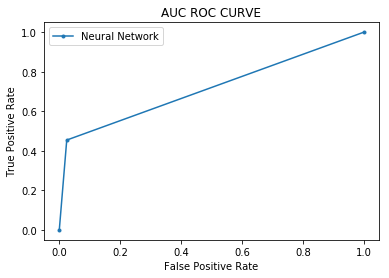

In [32]:
plt.title('AUC ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.plot(cr_fpr, cr_tpr, linestyle='--',linewidth=3, label='CRIB')
#plt.plot(cr2_fpr, cr2_tpr, 'r+',linestyle='--', label='CRIB II')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
#plt.plot(ns_fpr, ns_tpr, linestyle='--', label='SNAPPE II')
#plt.plot(ns2_fpr, ns2_tpr, linestyle='--', label='SNAP II')
#plt.plot(log_fpr, log_tpr, marker='.', label='Logistic Regression')
plt.legend(loc=0)
#plt.savefig('AUC_2.png',dpi=1200)

In [33]:
roc_auc_score(complete_df.dischargestatus,complete_df.pred)

0.715034965034965

In [34]:
#complete_df.to_csv('CRIB_2_10_JAN.csv')

In [35]:
#reports
#Results might vary with each iteration as Deep Neural Networks,initially assigns random weights.
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(complete_df.dischargestatus,np.round(complete_df.pred)))
print(confusion_matrix(complete_df.dischargestatus,np.round(complete_df.pred)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1144
           1       0.26      0.45      0.33        22

   micro avg       0.97      0.97      0.97      1166
   macro avg       0.63      0.72      0.66      1166
weighted avg       0.98      0.97      0.97      1166

[[1116   28]
 [  12   10]]


In [36]:
len(complete_df)

1166

In [37]:
crib_2 = pd.DataFrame(complete_df.dischargestatus)

In [38]:
crib_2['pred'] = complete_df.pred

In [39]:
crib_2.to_csv('crib_2_AUC_ROC_6th_may.csv')